# Import Statements and Mount Drive

In [ ]:
!pip install datasets --quiet
!pip install evaluate --quiet
!pip install rouge_score --quiet
!pip install accelerate -U --quiet
#!pip install bitsnbytes --quiet
!pip install -i https://pypi.org/simple/ bitsandbytes --quiet
!pip install quanto --quiet
!pip install --upgrade transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 34.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq
import evaluate
import numpy as np
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import pipeline
from transformers import TrainingArguments, Trainer, logging
from accelerate import Accelerator
from transformers import AutoProcessor
from transformers import AutoModelForCausalLM
import torch
from torch.utils.data import DataLoader
import os
from PIL import Image
import json
import bitsandbytes
import accelerate
from transformers import Blip2Processor, Blip2ForConditionalGeneration, QuantoConfig
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = r"/content/drive/MyDrive/LLM Project/Formatted_Data"
dataset = load_dataset(dataset_path)
test_ds, val_ds, train_ds = dataset['test'], dataset['validation'], dataset['train']

Resolving data files:   0%|          | 0/6066 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/759 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/760 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
test_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 759
})

In [ ]:
val_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 758
})

In [ ]:
train_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 6065
})

# Preprocessing

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset

class PoemDataset(Dataset):
  #initialize
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  #need this function for the dataloader
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    enc = self.processor(images=item["image"], text=item["text"], padding="max_length",max_length=512, return_tensors="pt")

    # remove batch dimension
    enc = {k:v.squeeze() for k,v in enc.items()}
    return enc

In [ ]:
train_dataset = PoemDataset(train_ds, processor)
val_dataset = PoemDataset(val_ds,processor)
test_dataset = PoemDataset(test_ds,processor)

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)
val_dataloader = DataLoader(val_dataset,shuffle = True, batch_size = 2)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items(): print(k,v.shape)

pixel_values torch.Size([2, 3, 224, 224])
input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])


In [ ]:
batch = next(iter(val_dataloader))
for k,v in batch.items(): print(k,v.shape)

pixel_values torch.Size([2, 3, 224, 224])
input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])


# Loading Model and Initial Loss

In [ ]:
#load quantized version of model
quantization_config = QuantoConfig(weights="int8")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", quantization_config=quantization_config)

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#check initial loss on a batch
outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], pixel_values=batch["pixel_values"], labels=batch["input_ids"])
outputs.loss

tensor(16.5307, grad_fn=<NllLossBackward0>)

# Fine Tuning

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"

#Gradient Accumulation
accelerator = Accelerator(gradient_accumulation_steps=4)
model.to(device)

model.train()

# Training loop
for epoch in range(1):
  for batch in train_loader:
    with accelerator.accumulate(model):
      #Grab input ids, pixels, and attention mask
      input_ids = batch.pop("input_ids").to(device)
      pixel_values = batch.pop("pixel_values").to(device)
      attention_mask = batch.pop('attention_mask').to(device)

      #pass inputs through model
      outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, labels=input_ids)

      #calculate loss and perform updates
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      #print loss
      print(f"Training loss: {loss.item()}")

Training loss: 15.303229331970215
Training loss: 16.4925537109375
Training loss: 15.182357788085938
Training loss: 15.642518997192383
Training loss: 15.872156143188477
Training loss: 14.160675048828125
Training loss: 14.186066627502441
Training loss: 13.842422485351562
Training loss: 15.540462493896484
Training loss: 15.600781440734863
Training loss: 15.034693717956543
Training loss: 12.82683277130127
Training loss: 13.569334030151367
Training loss: 14.037013053894043
Training loss: 13.781946182250977
Training loss: 13.670768737792969
Training loss: 12.965235710144043
Training loss: 12.294938087463379
Training loss: 13.911490440368652
Training loss: 11.886165618896484
Training loss: 11.994479179382324
Training loss: 12.569038391113281
Training loss: 11.572084426879883
Training loss: 11.64961051940918
Training loss: 11.985487937927246
Training loss: 12.352019309997559
Training loss: 12.350038528442383
Training loss: 10.86349105834961
Training loss: 11.97872543334961
Training loss: 11.36

In [ ]:
# save model
torch.save(model.state_dict(), "finetuned_model_blip_v1")

# save optimizer
torch.save(optimizer.state_dict(), "optimizer_state_blip_v1")

# Reload Saved Model and Generate Poems for Sample Images

In [ ]:
#load model
test_path = r"/content/drive/MyDrive/LLM Project/Formatted_Data/test"
train_path = r"/content/drive/MyDrive/LLM Project/Formatted_Data/train"

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

trained_model =  Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", quantization_config=quantization_config)
trained_optimizer = torch.optim.AdamW(trained_model.parameters(), lr=5e-5)

# Load the saved model and optimizer state
trained_model.load_state_dict(torch.load(r'/content/finetuned_model_blip_v1'))
trained_optimizer.load_state_dict(torch.load(r'/content/optimizer_state_blip_v1'))

# Set the model to evaluation mode for inference
trained_model.eval()

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): QLinear(in_features=1408, out_features=4224, bias=True)
            (projection): QLinear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): QLinear(in_features=1408, out_features=6144, bias=True)
            (fc2): QLinear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNo

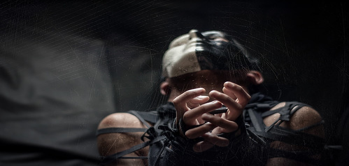

i am the one who knocks



In [ ]:
#load in image
image = os.listdir(train_path)[3]
image_path = os.path.join(train_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens=True)[0]
print(gen_poem)

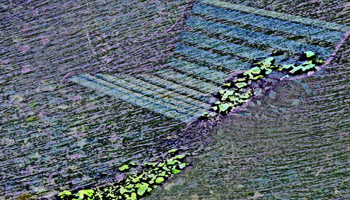

i am the one who knocks



In [ ]:
#load in image
image = os.listdir(train_path)[1]
image_path = os.path.join(train_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens=True)[0]
print(gen_poem)

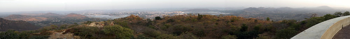

theres a certain feeling of being in the presence of the universe



In [ ]:
#load in image
image = os.listdir(train_path)[2]
image_path = os.path.join(train_path, image)
image = Image.open(image_path)

#resize image for better display
width, height = image.size
display(image.resize((int(0.7*width), int(0.5*height))))

#generate poem
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values
gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
gen_poem = processor.batch_decode(gen_ids, skip_special_tokens=True)[0]
print(gen_poem)

# Evaluate ROUGE Scores on Test Set

In [ ]:
#load in rouge metric
rouge = evaluate.load('rouge')

#create poem dict from the metadata file
data_dict = {}
with open(r"/content/drive/MyDrive/LLM Project/Formatted_Data/train/metadata.jsonl", 'r') as file:
  for line in file:
    data = json.loads(line)
    filename = data['file_name']
    text = data['text']
    data_dict[filename] = text

In [ ]:
print(len(data_dict))

7582


In [ ]:
#store generated poems and the original (provided) poems
gen_p = []
orig_p = []
for filename in tqdm(os.listdir(test_path)):
  # Check if the file is an image (we want to ignore the metadata file in the folders)
  if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
    #open image with the file path
    path = test_path +'/'+ filename
    image = Image.open(path)

    #generate poem
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs.pixel_values
    gen_ids = trained_model.generate(pixel_values=pixel_values, max_length=50)
    gen_poem = processor.batch_decode(gen_ids, skip_special_tokens=True)[0]

    #append to lists
    gen_p.append(gen_poem)
    orig_p.append(data_dict[filename])


100%|██████████| 760/760 [2:16:02<00:00, 10.74s/it]


In [ ]:
rouge.compute(predictions = gen_p, references = orig_p)

{'rouge1': 0.07528563733593348,
 'rouge2': 0.005394538686383354,
 'rougeL': 0.06698777748108416,
 'rougeLsum': 0.07343775988423884}